In [3]:
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
from itertools import combinations
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from NNetwork import NNetwork as nn
from src.sampling.Sampling import sampling_sndl
from src.supervised_NDL.SNDL import sndl_equalEdge, sndl_predict
from util.plotting import *
from contextlib import contextmanager

In [4]:
@contextmanager
def suppress_output():
    # Redirect stdout to null
    with open(os.devnull, 'w') as fnull:
        original_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = original_stdout

## Binary Affinity Score Heatmap

In [5]:
def compute_latent_motifs_binary_all(graph_list, sample_size_list, k, n_components, iterations):
    motifs = {}
    for i, j in combinations(range(len(graph_list)), 2):
        print(f"Computing latent motifs for networks ({i}, {j})")
        X, y = sampling_sndl([graph_list[i], graph_list[j]], k=k, sample_size_list=sample_size_list)
        with suppress_output():
            W, beta, H = sndl_equalEdge([graph_list[i], graph_list[j]], sample_size_list, k=k, xi=2, n_components=n_components, iter=iterations)
        motifs[(i, j)] = (W, beta)
    return motifs

In [6]:
def compute_affinity_scores(motifs, graph_paths, sample_size_list, k, n_components, iterations):
    affinity_scores = {}
    num_graphs = len(graph_paths)
    
    for (i, j), (W, beta) in motifs.items():
        for l in range(num_graphs):
            print(f"Computing affinity score for pair ({i}, {j}) with test network {l}")
            G_test = nn.NNetwork()
            G_test.load_add_edges(graph_paths[l], increment_weights=False, use_genfromtxt=True)
            affinity_score = sndl_predict(G_test, W, beta, 1000)
            affinity_scores[(i, j, l)] = affinity_score
            del G_test  # Clear memory after usage
    return affinity_scores

In [7]:
def plot_affinity_heatmap_binary_all(affinity_scores, ntwk_list):
    num_graphs = len(ntwk_list)
    num_pairs = len(list(combinations(range(num_graphs), 2)))
    affinity_matrix = np.zeros((num_pairs, num_graphs))
    
    row_labels = []
    idx = 0
    
    for i, j in combinations(range(num_graphs), 2):
        row_labels.append(f'{ntwk_list[i]} & {ntwk_list[j]}')
        for l in range(num_graphs):
            affinity_matrix[idx, l] = affinity_scores[(i, j, l)]
        idx += 1

    col_labels = [ntwk for ntwk in ntwk_list]

    plt.figure(figsize=(10, 8))
    sns.heatmap(affinity_matrix, annot=True, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap='Blues')
    plt.xlabel('Test Network')
    plt.ylabel('Network Pair')
    plt.title('Affinity Scores Heatmap')
    plt.show()

In [8]:
def affinity_analysis_binary_all(ntwk_list, sample_size_list, k, n_components, iterations):
    graph_paths = [f"data/{ntwk}.txt" for ntwk in ntwk_list]
    graph_list = []

    for path in graph_paths:
        G = nn.NNetwork()
        G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
        graph_list.append(G)
    
    motifs = compute_latent_motifs_binary_all(graph_list, sample_size_list, k, n_components, iterations)
    affinity_scores = compute_affinity_scores(motifs, graph_paths, sample_size_list, k, n_components, iterations)
    plot_affinity_heatmap_binary_all(affinity_scores, ntwk_list)

Computing latent motifs for networks (0, 1)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:19<00:00, 12.83it/s]


Computing latent motifs for networks (0, 2)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:12<00:00, 19.84it/s]


Computing latent motifs for networks (0, 3)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:14<00:00, 17.46it/s]


Computing latent motifs for networks (1, 2)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:14<00:00, 17.33it/s]


Computing latent motifs for networks (1, 3)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:12<00:00, 19.38it/s]


Computing latent motifs for networks (2, 3)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


Computing affinity score for pair (0, 1) with test network 0
Computing affinity score for pair (0, 1) with test network 1
Computing affinity score for pair (0, 1) with test network 2
Computing affinity score for pair (0, 1) with test network 3
Computing affinity score for pair (0, 2) with test network 0
Computing affinity score for pair (0, 2) with test network 1
Computing affinity score for pair (0, 2) with test network 2
Computing affinity score for pair (0, 2) with test network 3
Computing affinity score for pair (0, 3) with test network 0
Computing affinity score for pair (0, 3) with test network 1
Computing affinity score for pair (0, 3) with test network 2
Computing affinity score for pair (0, 3) with test network 3
Computing affinity score for pair (1, 2) with test network 0
Computing affinity score for pair (1, 2) with test network 1
Computing affinity score for pair (1, 2) with test network 2
Computing affinity score for pair (1, 2) with test network 3
Computing affinity score

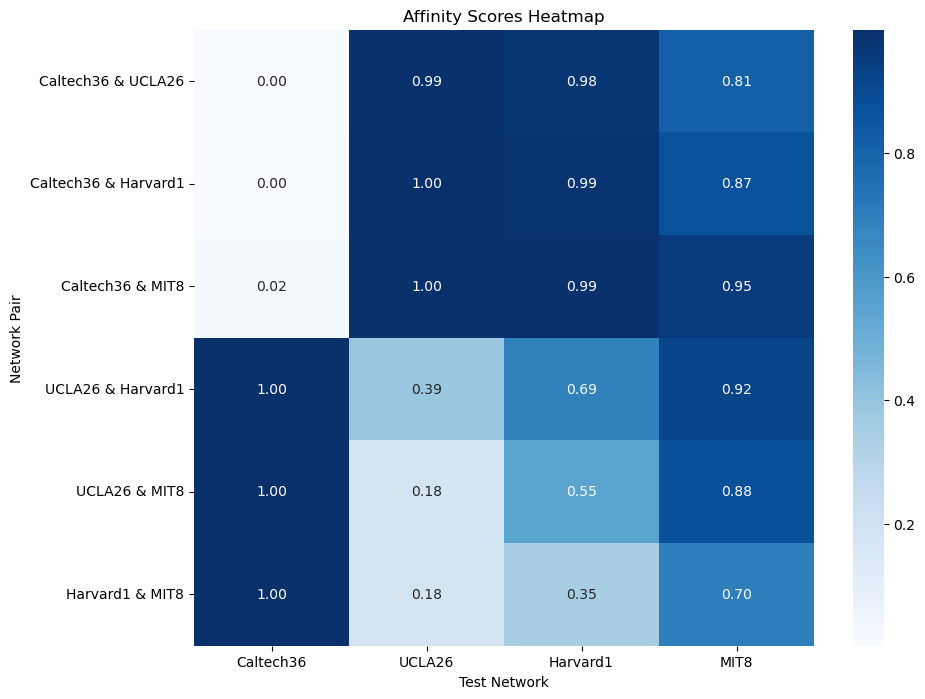

In [9]:
# Example usage
ntwk_list = ['Caltech36', 'UCLA26', 'Harvard1', "MIT8"]
sample_size_list = [500, 500]
k = 50
n_components = 16
iterations = 250

affinity_analysis_binary_all(ntwk_list, sample_size_list, k, n_components, iterations)

## Multiclass Prediction Plot

In [ ]:
def compute_latent_motifs_and_dictionary(ntwk_list, base_sample_size, k, xi, n_components, iterations):
    graph_list = []
    for ntwk in ntwk_list:
        path = "data/" + str(ntwk) + '.txt'
        G = nn.NNetwork()
        G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
        graph_list.append(G)
    
    with suppress_output():
        W, beta, H = sndl_equalEdge(graph_list, base_sample_size=base_sample_size, k=k, xi=xi, n_components=n_components, iter=iterations)
    return W, beta, H


def compute_prediction_scores(G, W, beta, sample_size):
    with suppress_output():
        prob_ = sndl_predict(G, W, beta, sample_size)
    prob = np.insert(prob_, 0, 1 - np.sum(prob_))
    print(f"Prediction scores (prob) for a network: {prob}")  # Debugging information
    return prob

def compute_affinity_scores_for_remaining_networks(ntwk_list, W, beta):
    affinity_scores = {}
    for ntwk in ntwk_list:
        path = "data/" + str(ntwk) + '.txt'
        G = nn.NNetwork()
        G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
        prob = compute_prediction_scores(G, W, beta, 500)
        affinity_scores[ntwk] = prob
    return affinity_scores

In [ ]:
def triangle_area(p1, p2, p3):
    p1, p2, p3 = np.array(p1, dtype=float), np.array(p2, dtype=float), np.array(p3, dtype=float)
    return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))

def plot_3d_affinity_scores(ntwk_list, affinity_scores, view_angle=(30, 60)):
    # Initialize 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot Standards
    standard_points = []
    for idx, ntwk in enumerate(ntwk_list[:3]):
        point = [idx == 0, idx == 1, idx == 2]
        standard_points.append(point)
        ax.scatter(point[0], point[1], point[2], color='black', s=50)

    # Plot prediction scores for all networks
    all_points = []
    for ntwk, prob in affinity_scores.items():
        point = np.array([prob[1], prob[2], prob[3]])
        all_points.append(point)
        ax.scatter(point[0], point[1], point[2], label=ntwk, s=50)
        ax.text(point[0], point[1], point[2], f'({prob[1]:.2f}, {prob[2]:.2f}, {prob[3]:.2f})')

    # Add a standard triangle
    tri_vertices = np.array(standard_points)
    tri = Poly3DCollection([tri_vertices], alpha=0.3, color='grey')
    ax.add_collection3d(tri)

    # Add a triangle formed by first three networks
    small_tri_vertices = np.array(all_points[0:3])
    small_tri = Poly3DCollection([small_tri_vertices], alpha=0.3, edgecolor='r', color='yellow')
    ax.add_collection3d(small_tri)

    # Calculate areas and ratio
    big_triangle_area = triangle_area(*tri_vertices)
    small_triangle_area = triangle_area(*small_tri_vertices)
    area_ratio = small_triangle_area / big_triangle_area

    # Add the area ratio to the plot
    ax.text2D(0.05, 0.95, f'Area Ratio = {small_triangle_area:.2f} / {big_triangle_area:.2f} = {area_ratio:.2f}', transform=ax.transAxes)
    
    # Add labels and legend
    ax.set_xlabel(ntwk_list[0])
    ax.set_ylabel(ntwk_list[1])
    ax.set_zlabel(ntwk_list[2])
    ax.set_title('3D Visualization of Predicted Network Similarities')
    ax.legend()

    # Set the viewing angle
    ax.view_init(elev=view_angle[0], azim=view_angle[1])

    plt.show()

In [ ]:
def plot_3d_prediction(ntwk_list, sample_size_list, k, n_components, iterations):
    # Compute latent motifs and dictionary for the first three networks
    W, beta, H = compute_latent_motifs_and_dictionary(ntwk_list, base_sample_size=600, k=k, xi=7, n_components=n_components, iterations=iterations)
    
    # Compute affinity scores for the remaining networks
    affinity_scores = compute_affinity_scores_for_remaining_networks(ntwk_list, W, beta)
    
    # Plot 3D affinity scores
    plot_3d_affinity_scores(ntwk_list, affinity_scores)

In [ ]:
# Example usage
ntwk_list = ['Caltech36', 'UCLA26', 'MIT8', 'Harvard1']
sample_size_list = [500, 500]
k = 40
n_components = 16
iterations = 250

plot_3d_prediction(ntwk_list, sample_size_list, k, n_components, iterations)